In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

Advancements in genomics and machine learning have revolutionized both fields and for instance have culminated in models of Virtual Cells which predict the effect that changes in the micro- and macro-environment of the cell (such as perturbing the age of the donor, the tissue the cell is in, the drug treatment, knock-outs from guide RNAs etc) have on gene expression. 

Conversely, models of Virtual Tissues aim to not only estimate the effect the environment has on the cell but also the effect that the cell has on its environment and overall tissue.

Celcomen attempts to handle this problem using a causally identifiable GenAI framework which consists of two parts: the inference module (CCE) which uses spatial transcriptomics data to learn the values of gene-gene forces (up to their Markov equivalence class) and disentangle them to intra- and inter-cellular components; and the generative module (SCE) which uses the learned gene-gene forces to predict the effect of spatial counterfactuals, such as gene knokouts and cell injections, on the tissue.

The required inputs are raw gene counts stored as anndata. Download the cell_feature_matrix and cells.csv.gz from [10x_human_glioblastoma](https://www.10xgenomics.com/datasets/ffpe-human-brain-cancer-data-with-human-immuno-oncology-profiling-panel-and-custom-add-on-1-standard) and extract them into a directory labelled "data" in the same directory as this notebook, before proceeding. 




# Pre-processing

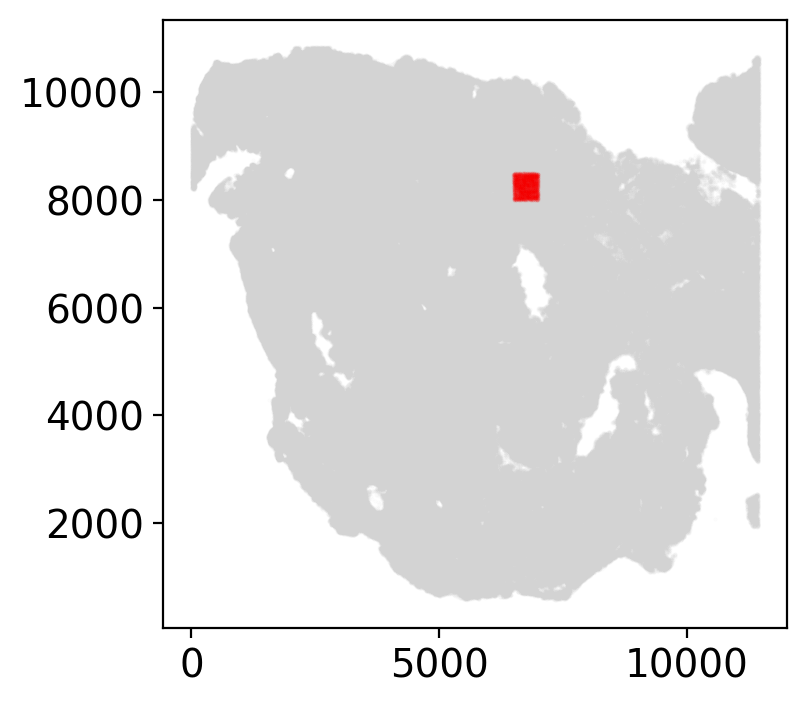

In [2]:
# read in xenium
avis = sc.read_10x_h5('data/xenium_human_gbm/cell_feature_matrix.h5')
avis.var_names = avis.var_names.astype(str)
avis.var_names_make_unique()
# remove cells with no counts
sc.pp.filter_cells(avis, min_counts=100)
# normalize the data
sc.pp.normalize_total(avis, target_sum=1e6)
sc.pp.log1p(avis)
# read in the spatial
df = pd.read_csv('data/xenium_human_gbm/cells.csv.gz', index_col=0)
df = df.loc[avis.obs.index]
# view the tissue and choose a specific area to focus on
fig, ax = plt.subplots()
ax.grid(False)
ax.scatter(df['x_centroid'], df['y_centroid'], s=0.1, alpha=0.1, color='lightgray')
mask = (df['x_centroid'] < 7000) & (df['x_centroid'] > 6500)
mask = mask & (df['y_centroid'] < 8500) & (df['y_centroid'] > 8000)
ax.scatter(df.loc[mask, 'x_centroid'], df.loc[mask, 'y_centroid'], s=0.1, alpha=0.1, color='r')

/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


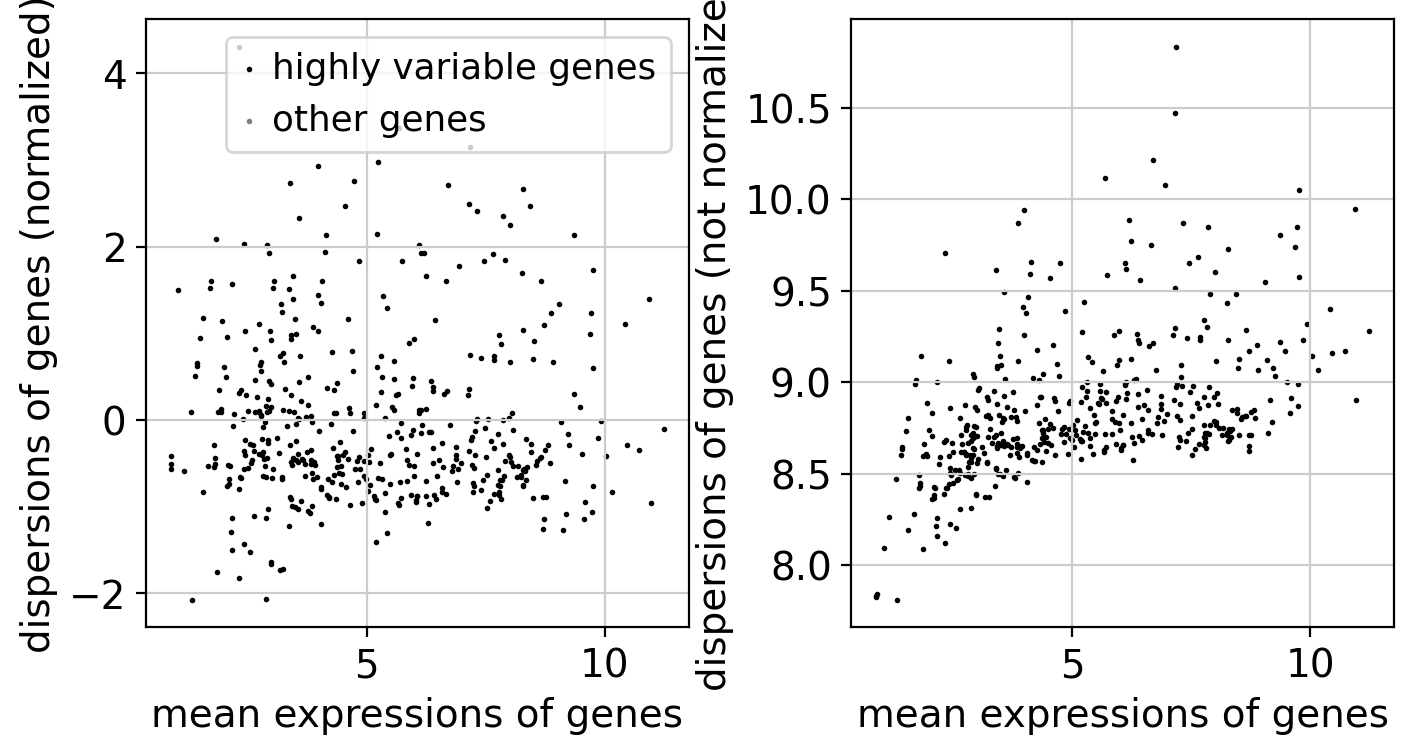

there are 480 hvgs


In [3]:
# add spatial and subset
avis.obsm['spatial'] = df.loc[avis.obs.index, ['x_centroid','y_centroid']].values
avis = avis[mask].copy()
# compute PCA for the spatial dataset using HVGs
avis.uns['log1p']['base'] = np.e
sc.pp.highly_variable_genes(avis, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5, n_top_genes=avis.shape[1])
sc.pl.highly_variable_genes(avis)
# report how many HVGs we're going to use
print('there are', avis.var['highly_variable'].sum(), 'hvgs')

In [4]:
from scipy.spatial.distance import pdist, squareform
# create a gene subset for testing
genes = avis.var_names[avis.var['highly_variable']].tolist()
avis = avis[:, genes ].copy()

# retrieve positions from the data # only needed for simcomen later
pos = torch.from_numpy(df[['x_centroid','y_centroid']].values)
# convert the gene expression data to numpy
x = torch.from_numpy(avis[:, genes].X.todense())
# sphere normalize the data (just in case)
norm_factor = torch.pow(x, 2).sum(1).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# compute the distances
distances = squareform(pdist(df.loc[mask, ['x_centroid','y_centroid']]))
# compute the edges as two cell widths apart so 30µm
edge_index = torch.from_numpy(np.array(np.where((distances < 15)&(distances != 0))))

avis.obs["sangerID"] = "sample1"

avis.write_h5ad(
    'data/xenium_human_gbm/avis_preprocessed.h5',
)

# Run inference module to learn intra- and inter-cellular gene-gene forces

In [5]:
# load model
from celcomen.models.celcomen import celcomen
from celcomen.models.simcomen import simcomen

from celcomen.training_plan.train import train
from celcomen.datareaders.datareader import get_dataset_loaders

from celcomen.utils.helpers import calc_gex, get_pos, get_pos, calc_sphex, normalize_g2g

In [6]:
h5ad_path='data/xenium_human_gbm/avis_preprocessed.h5'
n_neighbors=6
loader = get_dataset_loaders(h5ad_path, "sangerID", n_neighbors, 'cuda', True, )

Step 1
=====
Number of graphs in the current batch: 1
DataBatch(x=[1781, 480], edge_index=[2, 7724], y=[1], pos=[1781, 2], batch=[1781], ptr=[2])



### Select the hyperparameters of the model.
zmft_scalar should be the highest value in the range (0,1) such that the loss can be stably minimized. 
n_neighbors should be selected based on what disentanglement we want to achieve in the data. n_neighbors=6 targets disentanglement between intracellular and intercellular forces of short range.

In [7]:
n_genes = len(genes)
learning_rate = 5e-2
zmft_scalar = 1e-1
seed = 0
epochs = 200


model = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
model.to("cuda")
input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)

model.set_g2g(torch.from_numpy(input_g2g))
model.set_g2g_intra(torch.from_numpy(input_g2g))
model.to("cuda")

losses = train(epochs, learning_rate, model, loader, zmft_scalar=zmft_scalar, seed=1, device="cuda")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.60it/s]


[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

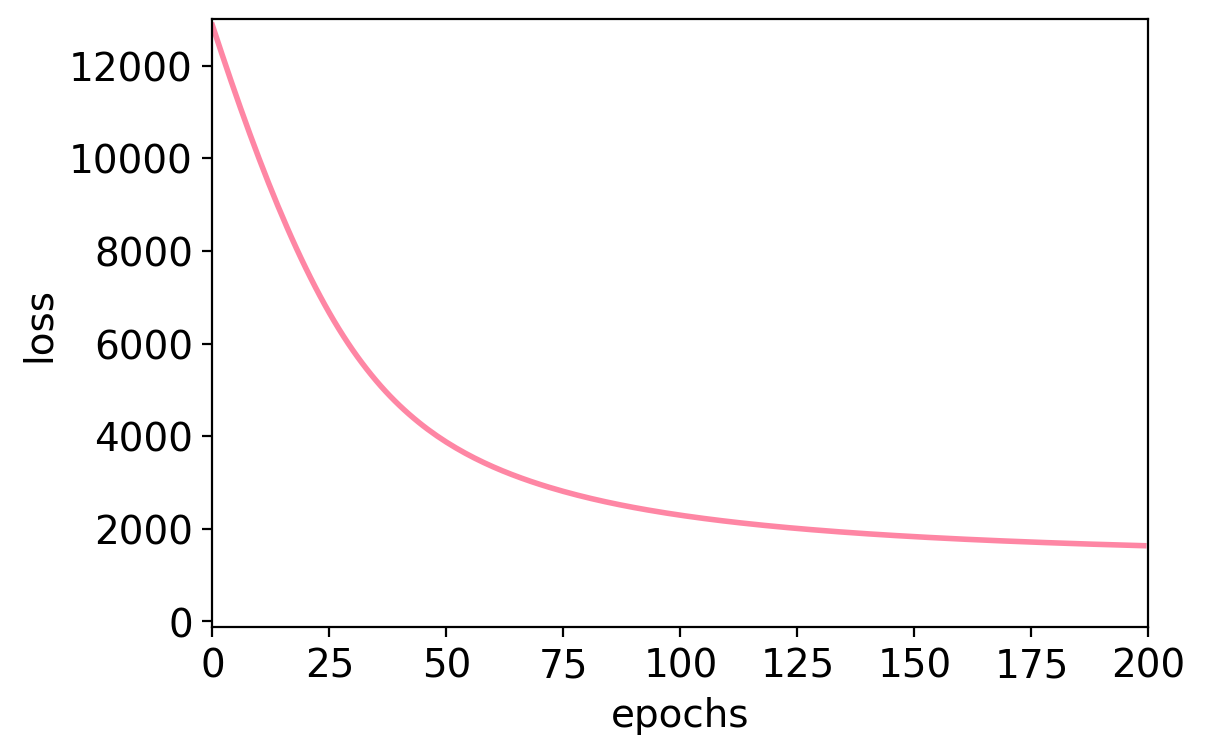

In [8]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

The stable optimization of Celcomen indicates that zmft_scalar has been chosen appropriately.

# Run the generative module: to predict the effect of cell insertions

The process of making a counterfactual prediction consists in: 

1) creating a prompt spatial transcriptomic dataset
2) use Simcomen (SCE) to make the counterfactual prediction based on the prompt

#### Create prompt 

In this tutorial we create a prompt as follows:
1) we find the spatial coordinates of the cell with the highest IFITM3 expression
2) we find the cell with the highest CD4 expression
3) paste a copy of the CD4+ cell 5μm away from the coordinates of the IFITM3+ cell

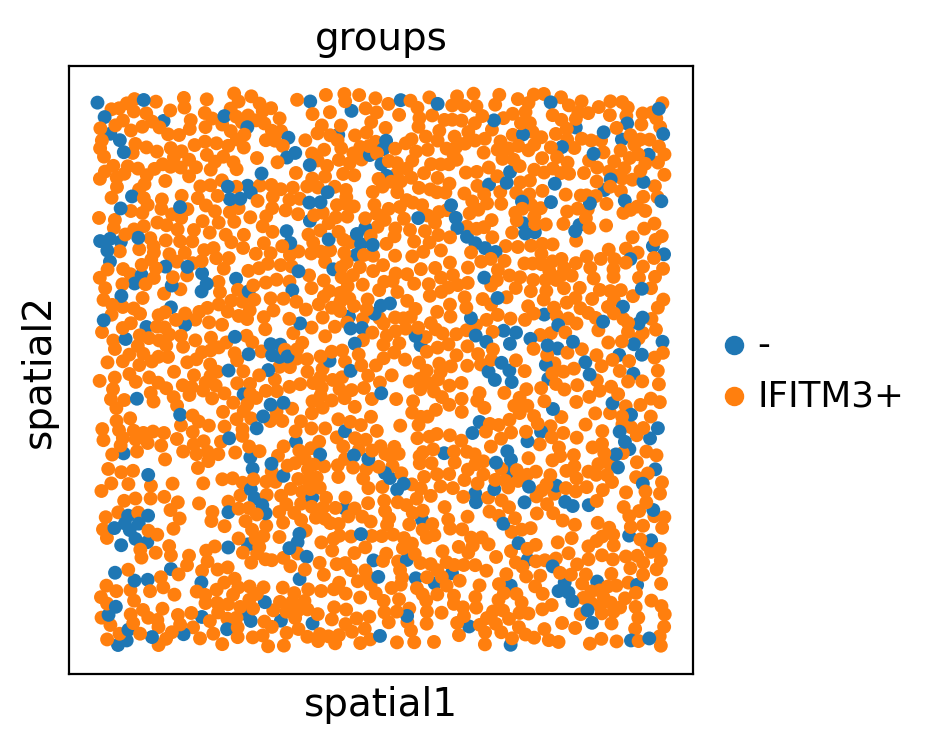

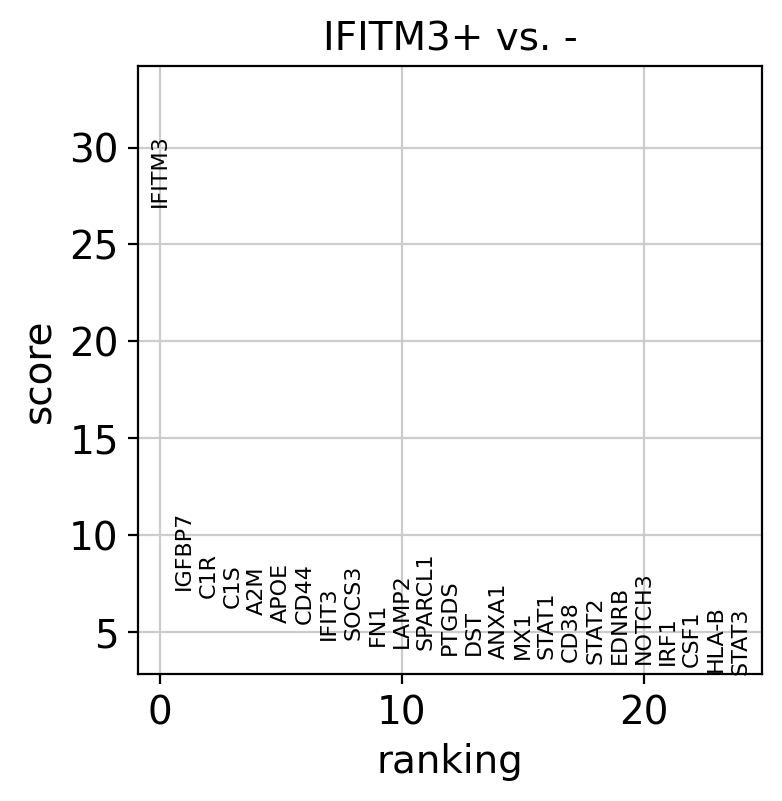

In [9]:
# define the genes that distinguish ISG15 spots currently
avis_sub = avis.copy()
avis_sub.obs['groups'] = (sc.get.obs_df(avis_sub, keys=['IFITM3']).max(1) > 0).map({True:'IFITM3+', False:'-'})
sc.pl.embedding(avis_sub, basis='spatial', color=['groups'], use_raw=False, s=1e2)
# calculate differential expression
sc.tl.rank_genes_groups(avis_sub, method='wilcoxon', use_raw=False, groupby='groups', group=['IFITM3+'], reference='-')
sc.pl.rank_genes_groups(avis_sub, n_genes=25, sharey=False)

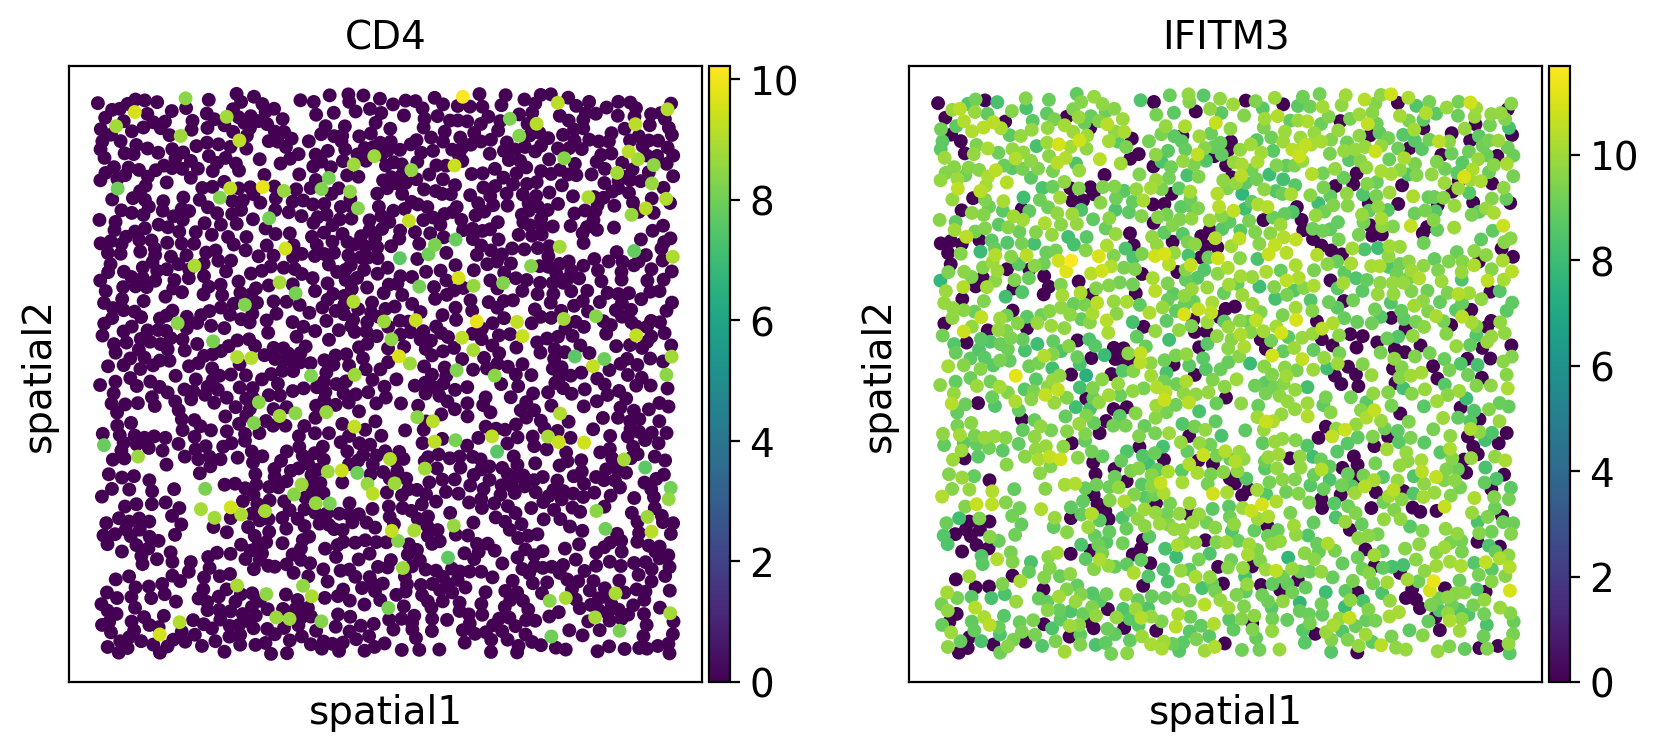

In [10]:
sc.pl.embedding(avis_sub, basis='spatial', color=['CD4','IFITM3'], use_raw=False, s=1e2)


In [11]:
# Extract spatial coordinates from avis_sub
spatial_coords = avis_sub.obsm["spatial"]

# Find the minimum and maximum values for x and y coordinates
x_min, y_min = spatial_coords.min(axis=0)
x_max, y_max = spatial_coords.max(axis=0)

print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")

x_min: 6500.10302734375, x_max: 6999.6416015625, y_min: 8000.41015625, y_max: 8499.4921875


In [12]:
# Ensure 'IFITM3' is in your gene list
if 'IFITM3' in avis_sub.var_names:
    # Get the expression values for IFITM3 across all cells
    ifitm3_expr = avis_sub[:, 'IFITM3'].X.toarray().flatten()  # convert to a 1D array

    # Find the index of the cell with the highest IFITM3 expression
    highest_ifitm3_cell_idx = np.argmax(ifitm3_expr)

    # Get the spatial coordinates of the cell with the highest IFITM3 expression
    ifitm3_highest_coords = avis_sub.obsm['spatial'][highest_ifitm3_cell_idx]

    print(f"Coordinates of the cell with the highest IFITM3 expression: {ifitm3_highest_coords}")
else:
    print("IFITM3 gene not found in dataset.")

Coordinates of the cell with the highest IFITM3 expression: [6615.68701172 8350.89648438]


In [13]:
new_coords = ifitm3_highest_coords.copy()
new_coords[0] = new_coords[0]+5
new_coords[1] = new_coords[1]+5
print(new_coords)

[6620.68701172 8355.89648438]


In [14]:
# Ensure 'CD4' is in your gene list
if 'CD4' in avis_sub.var_names:
    # Get the expression values for CD4 across all cells
    cd4_expr = avis_sub[:, 'CD4'].X.toarray().flatten()  # convert to a 1D array

    # Find the highest CD4 expression value
    max_cd4_expr = np.max(cd4_expr)

    # Find all cells that have this maximum CD4 expression value
    highest_cd4_cells = np.where(cd4_expr == max_cd4_expr)[0]

    # Randomly select one cell from the cells with the highest CD4 expression
    selected_cell_idx = np.random.choice(highest_cd4_cells)

    # Subset avis to get the cell with the highest CD4 expression
    avis_new_cell = avis_sub[selected_cell_idx, :].copy()

    # change the coordinates of the new cell to be clode to the highest IFITM3 cell
    avis_new_cell.obsm["spatial"] = np.array([new_coords])

    # Create a new avis_new which is a copy of the original avis
    avis_prompt = avis_sub.copy()

    # Stack avis_new and avis_sub (add the selected cell twice to the new object)
    avis_prompt = avis_prompt.concatenate([avis_new_cell])

    # Now avis_sub contains the single cell with the highest CD4 expression
    print(f"Randomly selected cell index: {selected_cell_idx}")
    print(f"avis_prompt: {avis_prompt}")
    
else:
    print("CD4 gene not found in dataset.")

Randomly selected cell index: 465
avis_prompt: AnnData object with n_obs × n_vars = 1782 × 480
    obs: 'n_counts', 'sangerID', 'groups', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'spatial'


/tmp/ipykernel_1433783/94626292.py:25: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  avis_prompt = avis_prompt.concatenate([avis_new_cell])


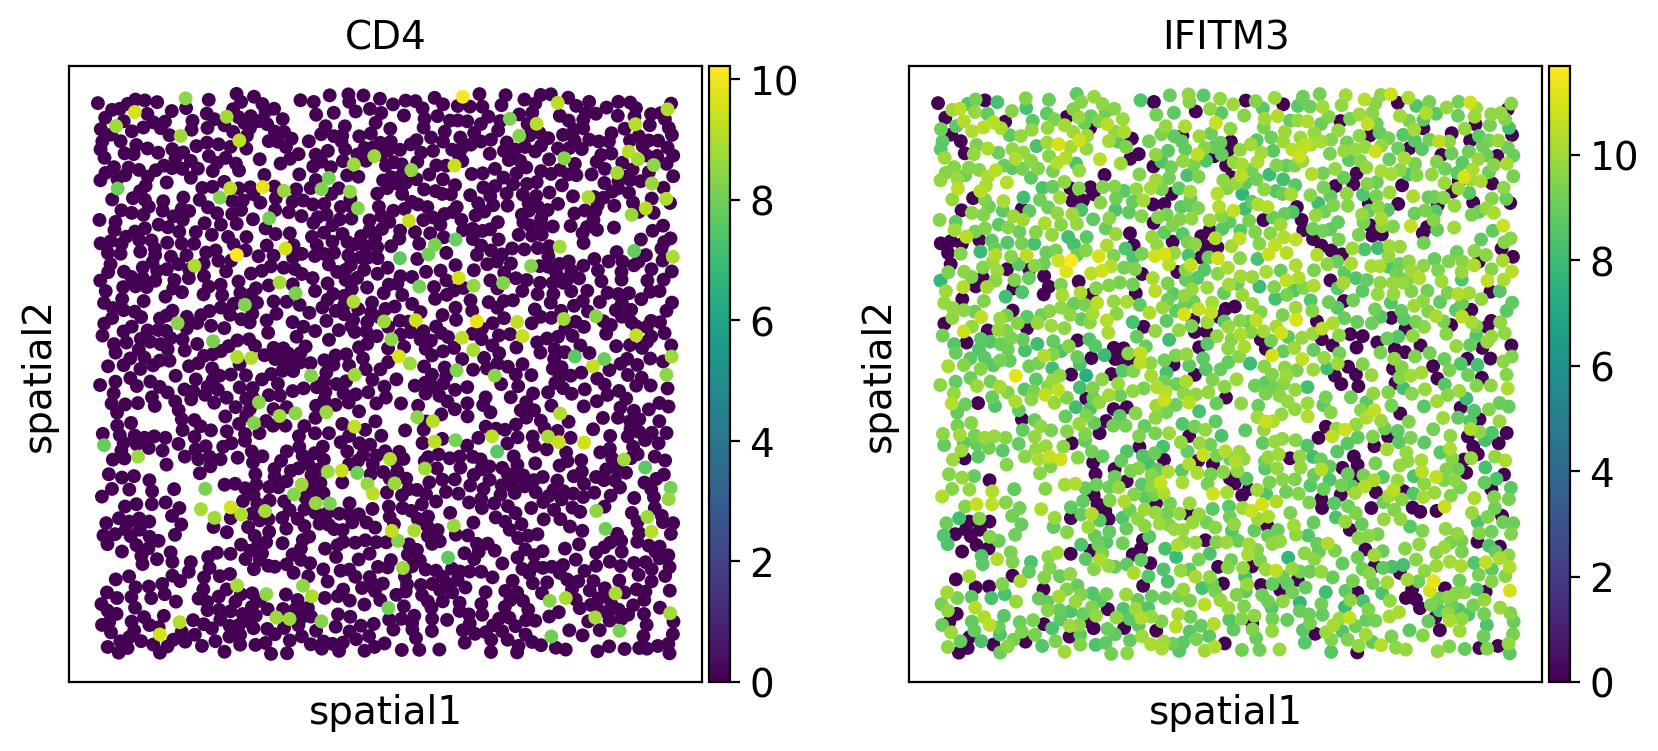

In [15]:
sc.pl.embedding(avis_prompt, basis='spatial', color=['CD4','IFITM3'], use_raw=False, s=1e2)

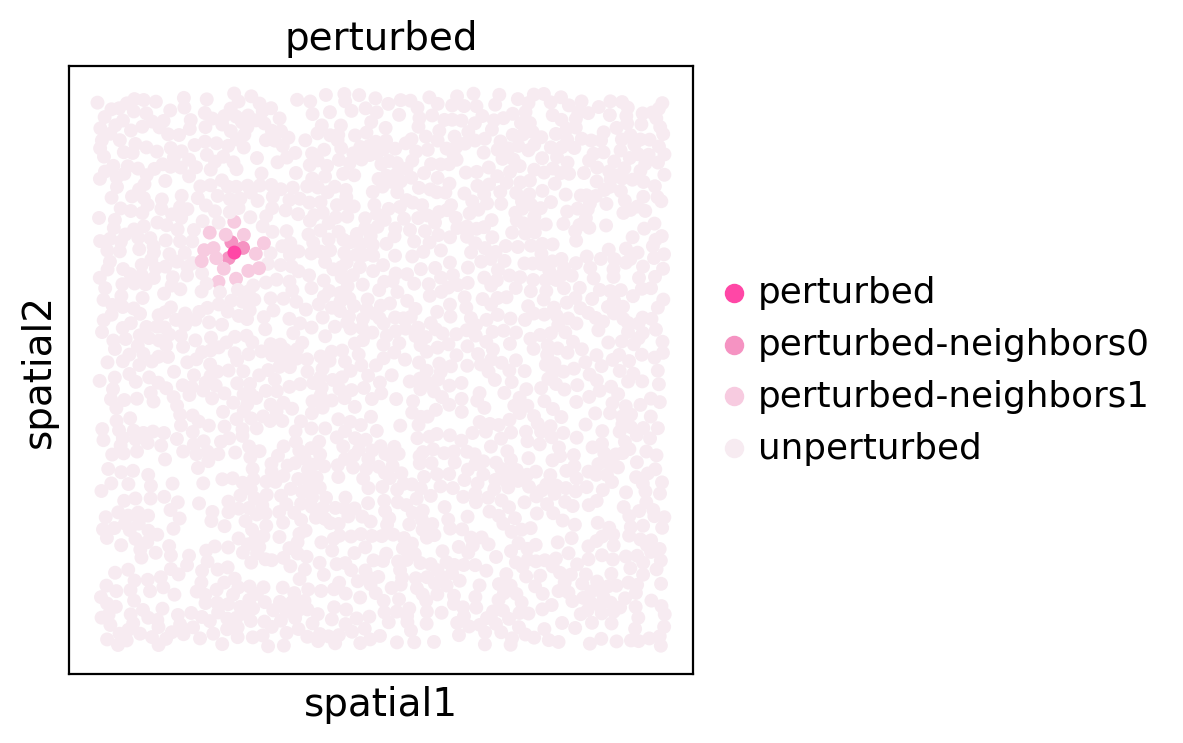

In [16]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import scanpy as sc

# Reset the 'perturbed' column to avoid accumulation
avis_prompt.obs['perturbed'] = 'unperturbed'

# Identify the index of the perturbed cell
perturbed_cell_index = avis_prompt.shape[0] - 1  # Assuming the last cell is perturbed

# Compute the distance matrix
distance_matrix = squareform(pdist(avis_prompt.obsm['spatial']))

# Get distances from the perturbed cell to all other cells
distances = distance_matrix[perturbed_cell_index, :]

# Find indices of neighbors within 30 units
neighbors_30 = np.where(distances < 30)[0]
avis_prompt.obs.iloc[neighbors_30, avis_prompt.obs.columns.get_loc('perturbed')] = 'perturbed-neighbors1'

# Find indices of neighbors within 15 units
neighbors_15 = np.where(distances < 15)[0]
avis_prompt.obs.iloc[neighbors_15, avis_prompt.obs.columns.get_loc('perturbed')] = 'perturbed-neighbors0'

# Annotate the perturbed cell itself
avis_prompt.obs.iloc[perturbed_cell_index, avis_prompt.obs.columns.get_loc('perturbed')] = 'perturbed'

# Set custom colors for visualization
avis_prompt.uns['perturbed_colors'] = ['#ff47a6', '#f593c2', '#f7cbe0', '#f7ebf1']

# Visualize the embedding with perturbed labels
sc.pl.embedding(avis_prompt, basis='spatial', color=['perturbed'], use_raw=False, s=1e2)

prompt_x = avis_prompt.X.toarray().copy()

### Run Simcomen

In [17]:
# define the parameters of the model
n_genes = avis_sub.shape[1]
learning_rate = 1e-3
zmft_scalar = 1e-1
seed = 0
epochs = 50
# instantiate the model, input and output will be the same
simmodel = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
# now perform the simulation
np.random.seed(seed)
# convert the gene expression data to numpy
x = torch.from_numpy(prompt_x)
# sphere normalize the data (just in case)
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# artifically set the g2g matrix
simmodel.set_g2g(model.conv1.lin.weight.clone().detach())
simmodel.set_g2g_intra(model.lin.weight.clone().detach())
# initialize a gene expression matrix
assert np.isnan(x.detach().numpy()).sum() == 0
input_sphex = calc_sphex(x.to('cuda')).clone()

# move tensors and model to device cuda
device="cuda"
simmodel.set_sphex(input_sphex)
simmodel.to(device)

# set up the optimizer
optimizer = torch.optim.SGD(simmodel.parameters(), lr=learning_rate, momentum=0)

In [18]:
# keep track of the losses per data object
loss, losses = None, []
# train the model
simmodel.train()
tmp_gexs = []
# work through epochs
edge_index = edge_index.to('cuda')
for epoch in tqdm(range(epochs), total=epochs):
    # derive the message as well as the mean field approximation
    msg, msg_intra, log_z_mft = simmodel(edge_index, 1)
    if (epoch % 5) == 0:
        tmp_gex = simmodel.gex.clone().detach().cpu().numpy()
        tmp_gexs.append(tmp_gex)
    # compute the loss and track it
    loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(simmodel.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
    losses.append(loss.detach().cpu().numpy()[0][0])
    # derive the gradients, update, and clear
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:52<00:00, 20.26s/it]


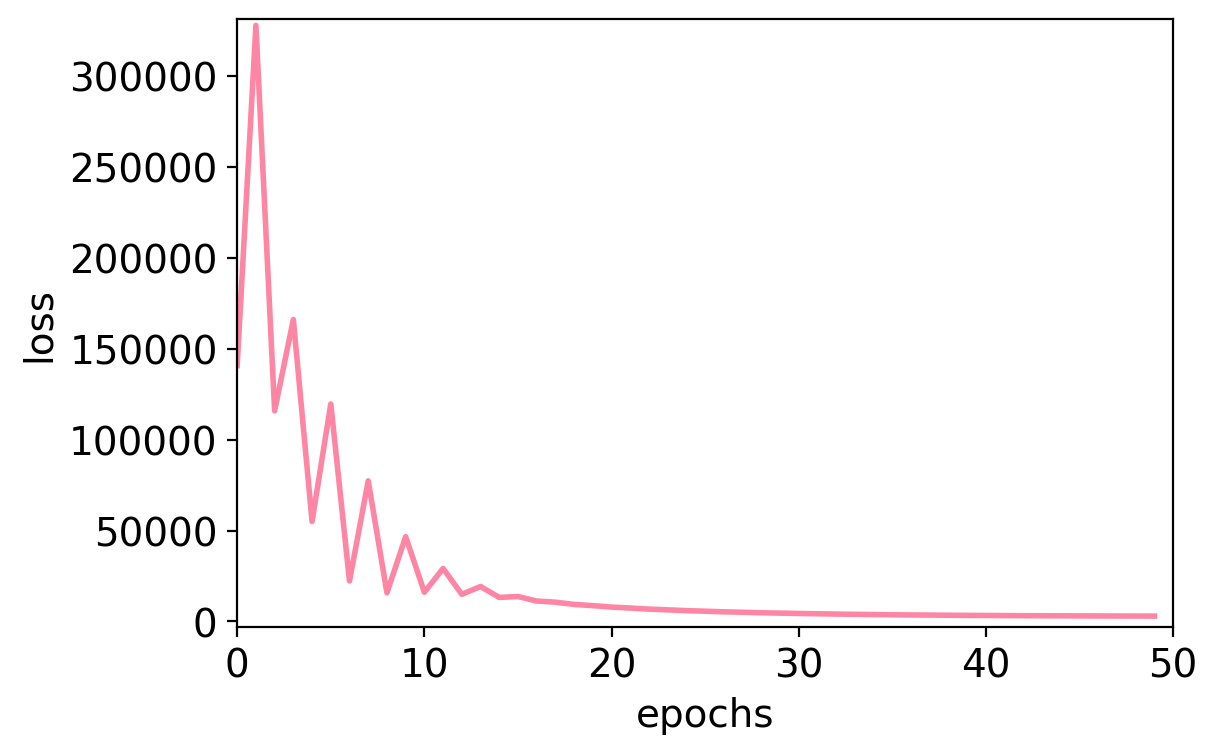

In [19]:
# plot the loss
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
# retrieve the data
output_gex = simmodel.gex.detach().cpu().numpy()
output_msg = msg.detach().cpu().numpy()

Stable optimization of Simcomen indicates that zmft_scalar has been chosen appropriately for this dataset.

# Visualization

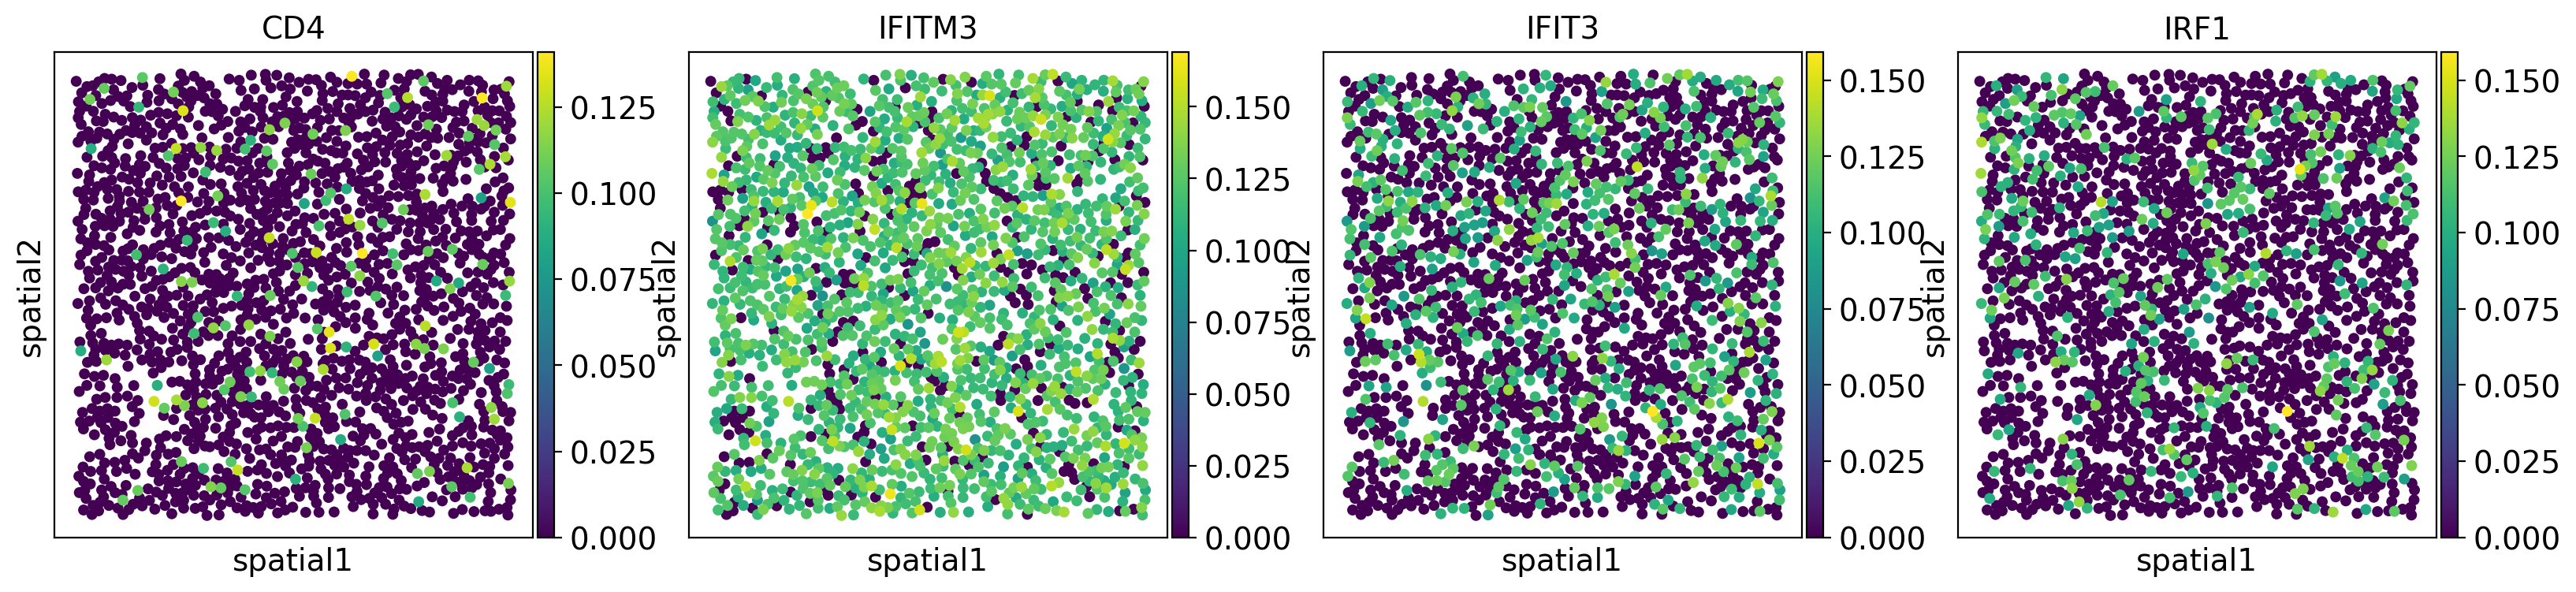

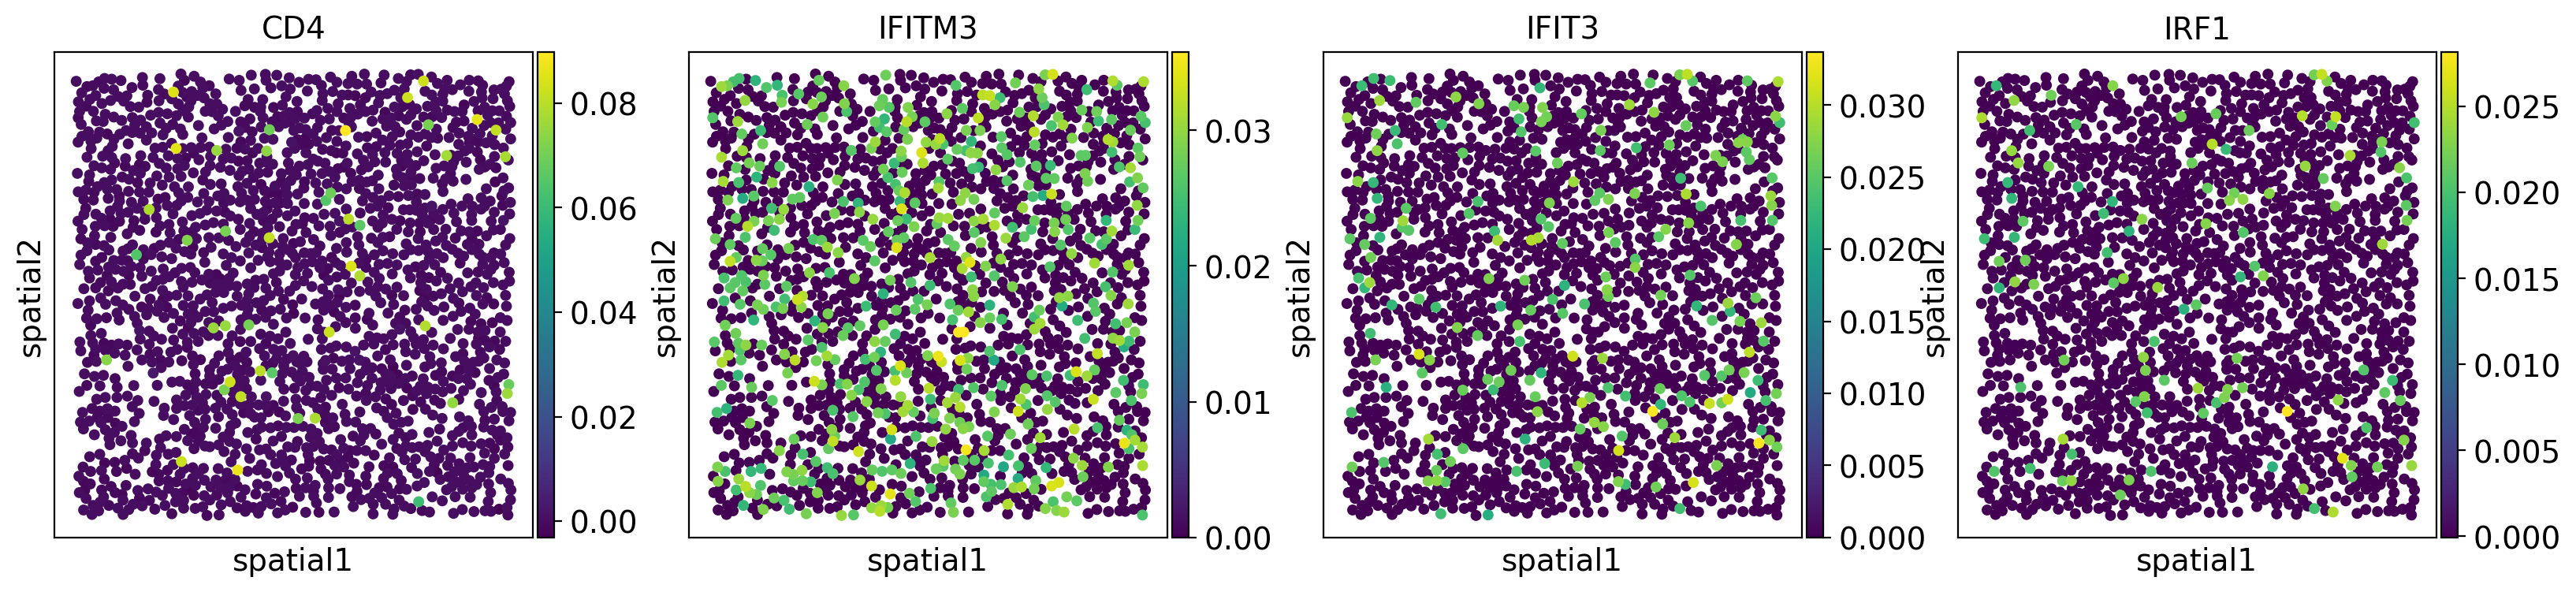

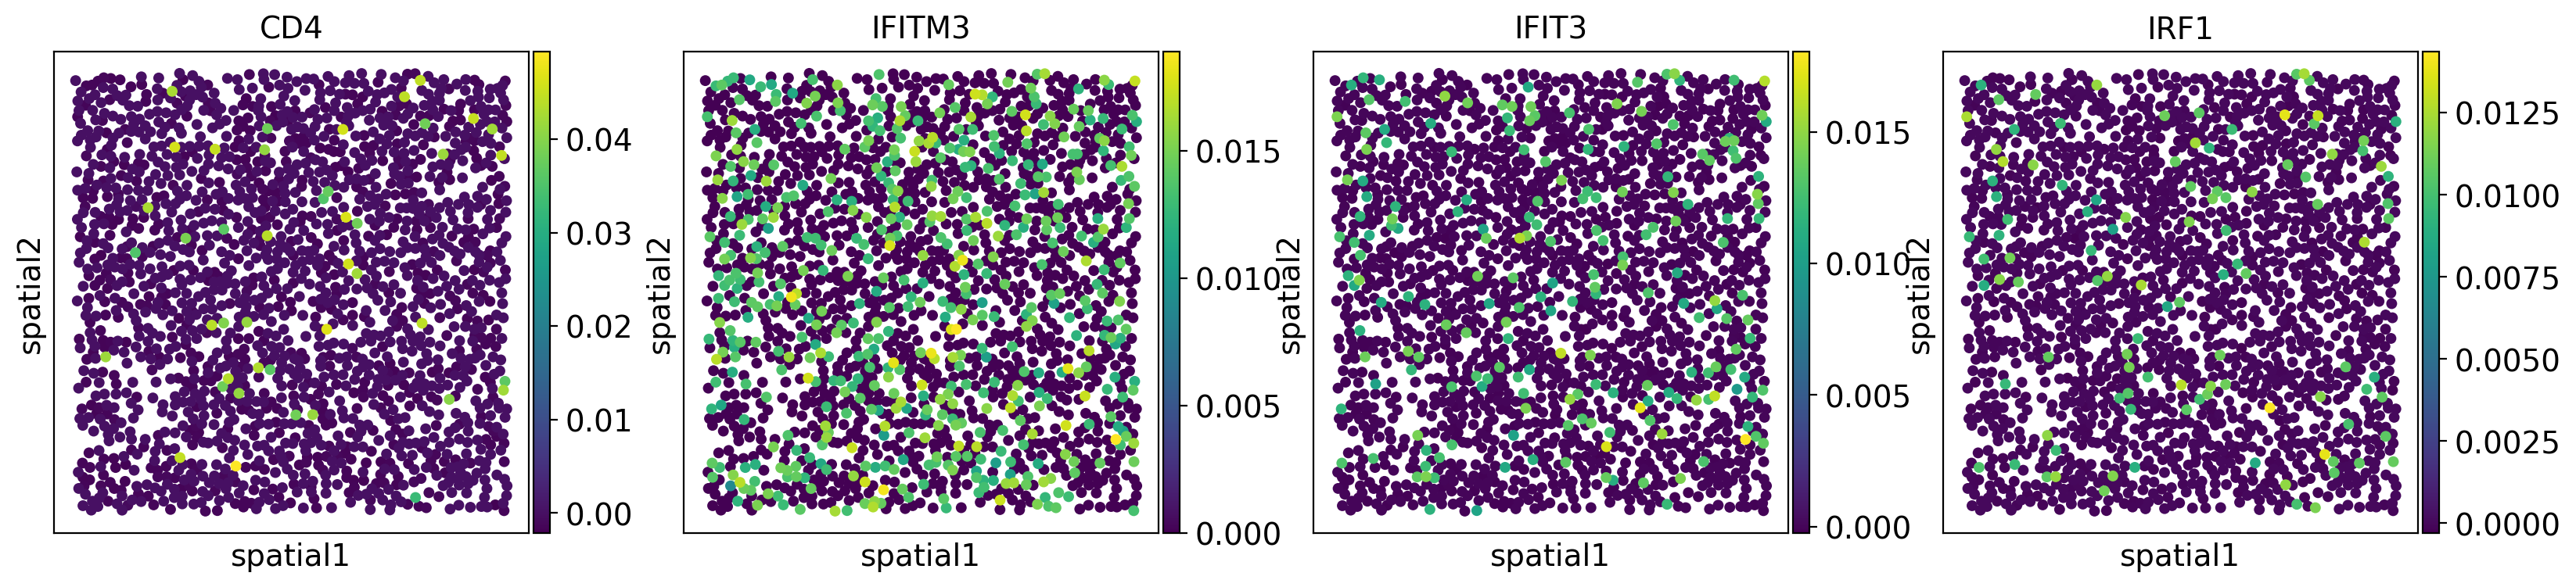

In [22]:
# find the genes of interest
genes = ['CD4','IFITM3','IFIT3','IRF1']
genes = [x for x in genes if x in avis_sub.var_names.tolist()]
# add the layers
for idx, tmp_gex in enumerate(tmp_gexs):
    avis_prompt.layers[f'input{idx}'] = tmp_gex
avis_prompt.layers['output'] = output_gex
# plot the genes of interest
sc.pl.embedding(avis_prompt, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input0')
sc.pl.embedding(avis_prompt, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input3')
sc.pl.embedding(avis_prompt, basis='spatial', color=genes, use_raw=False, s=1e2, layer='output')